In [1]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.5 MB/s eta 0:00:00


In [2]:
!pip install focal_loss -q

In [3]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import glob

In [4]:
from zipfile import ZipFile

In [5]:
import zipfile
import os

# Path to the uploaded ZIP file
zip_file_path = "/content/archive (2).zip"

# Extract to a specified directory
extract_path = "/content/extracted_files"

# Ensure the folder exists
os.makedirs(extract_path, exist_ok=True)

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Files extracted successfully to:", extract_path)

# List the files for confirmation
print("Extracted files:")
print(os.listdir(extract_path))

Files extracted successfully to: /content/extracted_files
Extracted files:
['Project Abstract Format.pdf', 'Image', 'Mask', 'metadata.csv']


In [6]:
images = sorted(glob.glob('/content/extracted_files/Image/*.jpg'))
masks = sorted(glob.glob('/content/extracted_files/Mask/*.png'))
len(images), len(masks)

(290, 290)

In [7]:
import numpy as np
import cv2
import os
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class CustomDataGenerator(keras.utils.Sequence):
    def __init__(self, images, masks, batch_size=8, img_size=(512, 512), shuffle=True):
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.images = images #os.listdir(image_folder)
        self.masks = masks #os.listdir(mask_folder)

        # on each epoch end, shuffle the dataset
        self.on_epoch_end()

        # datagen function to augment the input image and mask pair
        self.datagen = ImageDataGenerator(
            rotation_range=5,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.05,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode = 'constant',
            cval=0.0,
        )
     # randomly crop the images to 512x512 size
    def random_crop(self, image, mask, crop_size=512):

        # image width and height calculation
        img_height, img_width = image.shape[0], image.shape[1]
        mask_height, mask_width = mask.shape[0], mask.shape[1]

        # random x and y coordinate for cropping the image
        x = np.random.randint(0, img_width - crop_size)
        y = np.random.randint(0, img_height - crop_size)

        # random crop
        image_crop = image[y:y + crop_size, x:x + crop_size, :]
        mask_crop = mask[y:y + crop_size, x:x + crop_size]

        return image_crop, mask_crop

    # data augmentation using keras ImageDataGenerator function
    def data_augmentation(self, image, mask):
        trans_param = self.datagen.get_random_transform(image.shape)
        image = self.datagen.apply_transform(image, trans_param)
        mask = self.datagen.apply_transform(mask, trans_param)
        return image, mask

    # length of the processing batch
    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))
     # data normalization
    def data_normalization(self, image, mask):

        # reshape mask from 512x512 to 512x512x1
        mask = mask.reshape((*self.img_size, 1))

        # Binary mask
        mask = np.where(mask<127, 0, 1)

        # data normalization (If you want to normalize another way, change the below line)
        image = image / 255.0

        # return image and mask
        return image, mask

    # data preprocessing, resize, crop image etc
    def data_preprocessing(self, image, mask):
        image, mask = cv2.resize(image, (576, 576)), cv2.resize(mask, (576, 576))
        image, mask = self.random_crop(image, mask)
        return image, mask

    # on each epoch, shuffle the dataset (image and mask index)
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.images))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    # get item is the core function
    # this function will run in each batch/epoch to load the dataset into RAM and pass to DL model
    def __getitem__(self, index):

        # start and end index
        # the last index can be shorter than the number of batches
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.images))
        indexes = self.indexes[start_idx:end_idx]
         # initialize the images and mask batches
        batch_images = []
        batch_masks = []

        # iterate over each indexes in batch
        for i in indexes:
            img_path = self.images[i]
            mask_path = self.masks[i]

            # read image using open cv
            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Skip if image or mask is not loaded properly
            if img is None or mask is None:
                continue

            # image preprocessing; resize, random crop
            img, mask = self.data_preprocessing(img, mask)

            # data normalization
            img, mask = self.data_normalization(img, mask)

            # data augmentation
            img, mask = self.data_augmentation(img, mask)

            # to fix the issue during training process
            mask = mask.astype(np.float32)

            # append each image, mask pair to the batches
            batch_images.append(img)
            batch_masks.append(mask)

        # return batch image and batch mamks as a numpy array (n, tile_x, tile_y, channels)
        return np.array(batch_images), np.array(batch_masks)

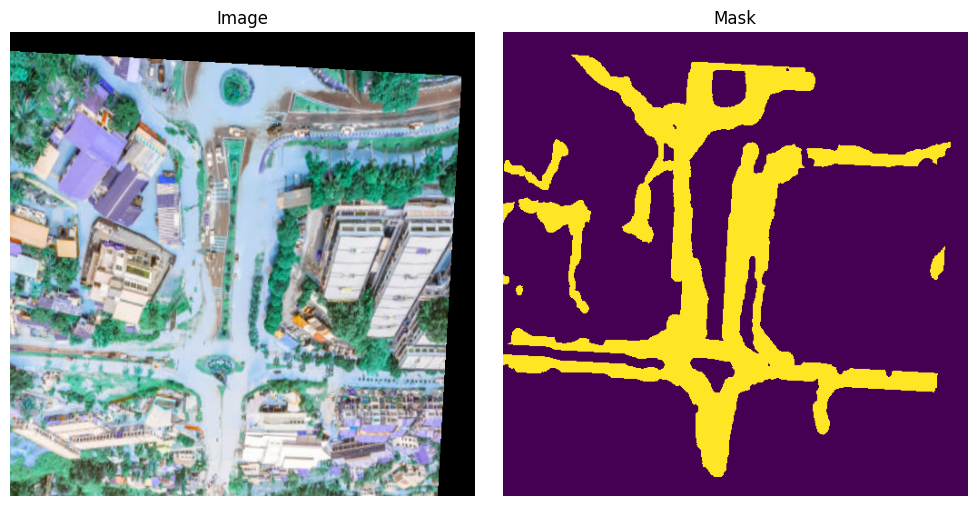

In [9]:
import matplotlib.pyplot as plt
import numpy as np

data = CustomDataGenerator(images, masks)
batch_images, batch_masks = data.__getitem__(0)

# Safe random index
img = np.random.randint(0, len(batch_images))

image = batch_images[img]
mask = batch_masks[img]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title('Mask')
plt.axis('off')

plt.tight_layout()
plt.show()


In [10]:

from sklearn.model_selection import train_test_split
train_img, test_img, train_mask, test_mask = train_test_split(images, masks, test_size=0.2, random_state=42)

In [11]:
len(train_img), len(test_img)

(232, 58)

In [12]:
train_dataset = CustomDataGenerator(train_img, train_mask)
test_dataset = CustomDataGenerator(test_img, test_mask)

In [13]:

len(train_dataset), len(test_dataset)

(29, 8)

In [14]:
import tensorflow as tf
from tensorflow.keras import backend as K

# recall
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#f1 score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

In [15]:
# weighted binary crosstropy function
def weighted_binary_crossentropy(y_true, y_pred, weights=[0.5, 0.5]):
    # Calculate weighted binary cross-entropy loss
    class_weighted_loss = BinaryCrossentropy(from_logits=True)
    loss = class_weighted_loss(y_true, y_pred)

    # Calculate class weights for each pixel in the mask
    weights = (1.0 - y_true) * weights[0] + y_true * weights[1]

    # Apply the class weights to the loss for each pixel
    weighted_loss = loss * weights

    # Compute the mean loss over all pixels
    return K.mean(weighted_loss)

In [16]:
# Wrapper function to switch between different loss functions
loss_functions = ['dice_loss', 'binary_crossentropy', 'wbcdl', 'focal_loss']
def get_loss_function(loss_name):
    if loss_name == 'dice_loss':
        return dice_loss
    elif loss_name == 'binary_crossentropy':
        return 'binary_crossentropy'
    elif loss_name == 'focal_loss':
        return BinaryFocalLoss(2.0)
    elif loss_name == 'wbcdl':
      return weighted_binary_crossentropy
    else:
        raise ValueError('Invalid loss function name')


activations = ['relu', 'lru']
def get_activation_function(activation):
  if activation == 'relu':
    return 'relu'
  elif activation == 'lru':
    return LeakyReLU()
  else:
    raise ValueError("Invalid activation function name!")

In [17]:
import tensorflow as tf

from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
from focal_loss import BinaryFocalLoss
# from utils.utils import f1_m, precision_m, recall_m, dsc

from sklearn.metrics import *

def expend_as(tensor, rep,name):
	my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep},  name='psi_up'+name)(tensor)
	return my_repeat

def AttnGatingBlock(x, g, inter_shape, activation, name):
    ''' take g which is the spatially smaller signal, do a conv to get the same
    number of feature channels as x (bigger spatially)
    do a conv on x to also get same geature channels (theta_x)
    then, upsample g to be same size as x
    add x and g (concat_xg)
    relu, 1x1 conv, then sigmoid then upsample the final - this gives us attn coefficients'''

    shape_x = K.int_shape(x)  # 32
    shape_g = K.int_shape(g)  # 16

    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same', name='xl'+name)(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(g)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),padding='same', name='g_up'+name)(phi_g)  # 16

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation(activation)(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same', name='psi'+name)(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = expend_as(upsample_psi, shape_x[3],  name)
    y = multiply([upsample_psi, x], name='q_attn'+name)

    result = Conv2D(shape_x[3], (1, 1), padding='same',name='q_attn_conv'+name)(y)
    result_bn = BatchNormalization(name='q_attn_bn'+name)(result)
    return result_bn
def UnetConv2D(input, outdim, is_batchnorm, activation, name):
	x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_1')(input)
	if is_batchnorm:
		x =BatchNormalization(name=name + '_1_bn')(x)
	x = Activation(activation,name=name + '_1_act')(x)

	x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_2')(x)
	if is_batchnorm:
		x = BatchNormalization(name=name + '_2_bn')(x)
	x = Activation(activation, name=name + '_2_act')(x)
	return x
def UnetGatingSignal(input, is_batchnorm, activation, name):
    ''' this is simply 1x1 convolution, bn, activation '''
    shape = K.int_shape(input)
    x = Conv2D(shape[3] * 1, (1, 1), strides=(1, 1), padding="same",  kernel_initializer=kinit, name=name + '_conv')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_bn')(x)
    x = Activation(activation, name = name + '_act')(x)
    return x

K.set_image_data_format('channels_last')  # TF dimension ordering in this code
kinit = 'glorot_normal'
def attn_unet(hp, pretrained_weights = None, input_size = (512,512,3)):

        # some hyperparameters
        filtersFirstLayer = hp.Choice('firstFilterLayer', [32,64,128])

        activation_func_name = hp.Choice('activations', activations)
        activation = get_activation_function(activation_func_name)

        is_batchnorm = hp.Boolean('is_batchnorm')
        lr = hp.Float('lr', min_value=0.0001, max_value=0.01, sampling='log')
        loss_func_name = hp.Choice('loss_func', loss_functions)
        loss_func = get_loss_function(loss_func_name)

        inputs = Input(shape=input_size)
        conv1 = UnetConv2D(inputs, filtersFirstLayer, is_batchnorm=is_batchnorm, activation=activation, name='conv1')
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = UnetConv2D(pool1, filtersFirstLayer, is_batchnorm=is_batchnorm, activation=activation, name='conv2')
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)


        conv3 = UnetConv2D(pool2, filtersFirstLayer*2, is_batchnorm=is_batchnorm, activation=activation, name='conv3')
        #conv3 = Dropout(0.2,name='drop_conv3')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

        conv4 = UnetConv2D(pool3, filtersFirstLayer*2, is_batchnorm=is_batchnorm, activation=activation, name='conv4')
        #conv4 = Dropout(0.2, name='drop_conv4')(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

        center = UnetConv2D(pool4, filtersFirstLayer*4, is_batchnorm=is_batchnorm, activation=activation, name='center')

        g1 = UnetGatingSignal(center, is_batchnorm=is_batchnorm, activation=activation, name='g1')
        attn1 = AttnGatingBlock(conv4, g1, filtersFirstLayer*4, activation, '_1')
        up1 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation=activation, kernel_initializer=kinit)(center), attn1], name='up1')

        g2 = UnetGatingSignal(up1, is_batchnorm=is_batchnorm, activation=activation, name='g2')
        attn2 = AttnGatingBlock(conv3, g2, filtersFirstLayer*2, activation, '_2')
        up2 = concatenate([Conv2DTranspose(filtersFirstLayer*2, (3,3), strides=(2,2), padding='same', activation=activation, kernel_initializer=kinit)(up1), attn2], name='up2')

        g3 = UnetGatingSignal(up1, is_batchnorm=is_batchnorm, activation=activation, name='g3')
        attn3 = AttnGatingBlock(conv2, g3, filtersFirstLayer, activation, '_3')
        up3 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation=activation, kernel_initializer=kinit)(up2), attn3], name='up3')

        up4 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation=activation, kernel_initializer=kinit)(up3), conv1], name='up4')
        conv10 = Conv2D(1, (1, 1), activation='sigmoid',  kernel_initializer=kinit, name='final')(up4)

        model = Model(inputs, conv10)

        model.compile(optimizer = Adam(learning_rate=lr), loss = loss_func, metrics = ['accuracy', f1_m, precision_m, recall_m, dsc])
        # model.summary()

        if(pretrained_weights):
            model.load_weights(pretrained_weights)

        return model

In [18]:
import tensorflow as tf
from tensorflow.keras import backend as K  # Use TensorFlow's Keras backend

def UnetGatingSignal(input, is_batchnorm, activation, name):
    ''' this is simply 1x1 convolution, bn, activation '''
    shape = K.int_shape(input)  # ✅ Use tf.keras.backend.int_shape()
    x = tf.keras.layers.Conv2D(
        shape[3] * 1, (1, 1), strides=(1, 1), padding="same",
        kernel_initializer="he_normal", name=name + '_conv'
    )(input)
    return x

In [19]:
import keras_tuner
model = attn_unet(keras_tuner.HyperParameters())

In [20]:
# Initialize the tuner (e.g., RandomSearch)
tuner = keras_tuner.RandomSearch(
    attn_unet,
    objective=keras_tuner.Objective("val_f1_m", direction="max"),  # Define the metric to optimize
    max_trials=15,                # Number of hyperparameter combinations to try
    directory='/content/extracted_files/',  # ✅ Correct: A valid directory, not a file
    project_name='flood_tuner'    # Name for the project
)


In [21]:
# Define training data and start the search
tuner.search(train_dataset, epochs=5, validation_data=test_dataset)  # ✅ Reduce epochs


Trial 15 Complete [00h 03m 55s]
val_f1_m: 0.5434160232543945

Best val_f1_m So Far: 0.8085363507270813
Total elapsed time: 00h 57m 46s


In [23]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
firstFilterLayer (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
activations (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'lru'], 'ordered': False}
is_batchnorm (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
loss_func (Choice)
{'default': 'dice_loss', 'conditions': [], 'values': ['dice_loss', 'binary_crossentropy', 'wbcdl', 'focal_loss'], 'ordered': False}


In [24]:

models = tuner.get_best_models(num_models=1)
best_model = models[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 146 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [25]:

best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_1 (Conv2D)    │ (None, 512, 512,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_1_act         │ (None, 512, 512,  │          0 │ conv1_1[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_2 (Conv2D)    │ (None, 512, 512,  │      9,248 │ conv1_1_act[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_2_act         │ (None, 512, 512,  │          0 │ conv1_2[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv1_2_act[0][0] │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1 (Conv2D)    │ (None, 256, 256,  │      9,248 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_act         │ (None, 256, 256,  │          0 │ conv2_1[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_2 (Conv2D)    │ (None, 256, 256,  │      9,248 │ conv2_1_act[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_2_act         │ (None, 256, 256,  │          0 │ conv2_2[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2_2_act[0][0] │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3_1 (Conv2D)    │ (None, 128, 128,  │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3_1_act         │ (None, 128, 128,  │          0 │ conv3_1[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3_2 (Conv2D)    │ (None, 128, 128,  │     36,928 │ conv3_1_act[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3_2_act         │ (None, 128, 128,  │          0 │ conv3_2[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv3_2_act[0][0] │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv4_1 (Conv2D)    │ (None, 64, 64,    │     36,928 │ max_pooling2d_2[

 Total params: 845,476 (3.23 MB)

 Trainable params: 845,156 (3.22 MB)

 Non-trainable params: 320 (1.25 KB)

In [26]:
# callback functions
checkpointer = tf.keras.callbacks.ModelCheckpoint(f"/content/drive/MyDrive/dl/flood/flood_best.h5", monitor="val_f1_m", verbose=1, save_best_only=True, mode="max")
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_m', patience=5, verbose=1, mode='max')

callbacks = [
    earlyStopping,
    checkpointer
    ]

# model training
history = model.fit(train_dataset,epochs=50,
                    verbose = 1,
                    # validation_split=0.15,
                    validation_data=test_dataset,
                    callbacks=callbacks)

# save the model weights at the end of the training process
model.save(f"/content/drive/MyDrive/dl/flood/flood_save.h5")

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5164 - dsc: 0.4521 - f1_m: 0.5834 - loss: 0.5480 - precision_m: 0.4294 - recall_m: 0.9265
Epoch 1: val_f1_m improved from -inf to 0.55489, saving model to /content/drive/MyDrive/dl/flood/flood_best.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.5179 - dsc: 0.4529 - f1_m: 0.5843 - loss: 0.5471 - precision_m: 0.4303 - recall_m: 0.9270 - val_accuracy: 0.3946 - val_dsc: 0.4811 - val_f1_m: 0.5549 - val_loss: 0.5223 - val_precision_m: 0.3855 - val_recall_m: 1.0000
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.6919 - dsc: 0.5674 - f1_m: 0.6816 - loss: 0.4325 - precision_m: 0.5517 - recall_m: 0.9129
Epoch 2: val_f1_m improved from 0.55489 to 0.57006, saving model to /content/drive/MyDrive/dl/flood/flood_best.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6930 - dsc: 0.5683 - f1_m: 0.6824 - loss: 0.4316 - precision_m: 0.5529 - recall_m: 0.9127 - val_accuracy: 0.4653 - val_dsc: 0.5163 - val_f1_m: 0.5701 - val_loss: 0.4757 - val_precision_m: 0.4014 - val_recall_m: 0.9999
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.7912 - dsc: 0.6677 - f1_m: 0.7552 - loss: 0.3324 - precision_m: 0.6709 - recall_m: 0.8746
Epoch 3: val_f1_m improved from 0.57006 to 0.60442, saving model to /content/drive/MyDrive/dl/flood/flood_best.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7916 - dsc: 0.6682 - f1_m: 0.7554 - loss: 0.3320 - precision_m: 0.6712 - recall_m: 0.8745 - val_accuracy: 0.5449 - val_dsc: 0.5522 - val_f1_m: 0.6044 - val_loss: 0.4400 - val_precision_m: 0.4383 - val_recall_m: 0.9878
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.8412 - dsc: 0.7577 - f1_m: 0.8023 - loss: 0.2422 - precision_m: 0.7708 - recall_m: 0.8436
Epoch 4: val_f1_m improved from 0.60442 to 0.73086, saving model to /content/drive/MyDrive/dl/flood/flood_best.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8407 - dsc: 0.7570 - f1_m: 0.8014 - loss: 0.2428 - precision_m: 0.7695 - recall_m: 0.8433 - val_accuracy: 0.7538 - val_dsc: 0.6155 - val_f1_m: 0.7309 - val_loss: 0.3723 - val_precision_m: 0.6028 - val_recall_m: 0.9340
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - accuracy: 0.8244 - dsc: 0.7495 - f1_m: 0.7662 - loss: 0.2501 - precision_m: 0.7200 - recall_m: 0.8276
Epoch 5: val_f1_m did not improve from 0.73086
29/29 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8246 - dsc: 0.7500 - f1_m: 0.7665 - loss: 0.2497 - precision_m: 0.7209 - recall_m: 0.8273 - val_accuracy: 0.7906 - val_dsc: 0.5553 - val_f1_m: 0.6413 - val_loss: 0.4489 - val_precision_m: 0.8837 - val_recall_m: 0.5090
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 0.8327 - dsc: 0.7829 - f1_m: 0.7908 - loss: 0.2171 - precision_m: 0.7534 - recall_m: 0.8379
Epoch 6: val_f1_m improved from 0.73086 to 0.80496, saving model to /content/drive/MyDrive/dl/flood

29/29 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8327 - dsc: 0.7826 - f1_m: 0.7905 - loss: 0.2174 - precision_m: 0.7532 - recall_m: 0.8376 - val_accuracy: 0.8507 - val_dsc: 0.7235 - val_f1_m: 0.8050 - val_loss: 0.2771 - val_precision_m: 0.8085 - val_recall_m: 0.8128
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - accuracy: 0.8351 - dsc: 0.7856 - f1_m: 0.7909 - loss: 0.2143 - precision_m: 0.7813 - recall_m: 0.8073
Epoch 7: val_f1_m did not improve from 0.80496
29/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8351 - dsc: 0.7853 - f1_m: 0.7906 - loss: 0.2146 - precision_m: 0.7804 - recall_m: 0.8077 - val_accuracy: 0.6553 - val_dsc: 0.2478 - val_f1_m: 0.0776 - val_loss: 0.7521 - val_precision_m: 0.9099 - val_recall_m: 0.0415
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.8366 - dsc: 0.7837 - f1_m: 0.7880 - loss: 0.2163 - precision_m: 0.7581 - recall_m: 0.8259
Epoch 8: val_f1_m did not improve from 0.80496
29/29 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0

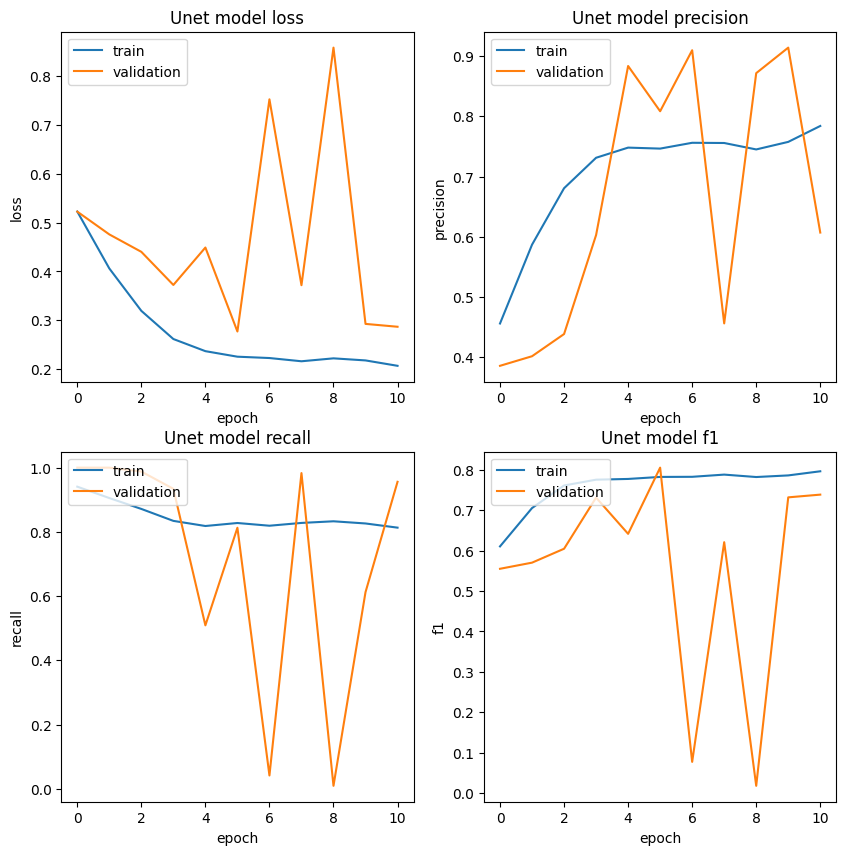

In [27]:


fig,((ax11, ax12),(ax13,ax14)) = plt.subplots(2,2,figsize=(10,10))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.title.set_text('Unet model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('Unet model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('Unet model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('Unet model f1')
ax14.set_ylabel('f1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Lambda

def custom_lambda(x):
    return x * 2  # Modify based on your actual Lambda function logic

layer = Lambda(custom_lambda, output_shape=(64, 64, 1))  # Explicit shape


In [29]:
import h5py

with h5py.File("/content/drive/MyDrive/dl/flood/flood_best.h5", "r") as f:
    print(list(f.keys()))  # Prints the main keys in the file


['model_weights', 'optimizer_weights']


In [57]:
# accuracy, f1_score, precision, recall, dsc = model.evaluate(test_dataset, verbose=0)
loss, accuracy, f1_score, precision, recall, dsc = model.evaluate(test_dataset, verbose=0)
print(loss, accuracy, f1_score, precision, recall, dsc)


0.28351739048957825 0.7333134412765503 0.7415273785591125 0.6104507446289062 0.9573819637298584 0.7334610223770142


# prediction on custom image

In [30]:
import glob
imgs = glob.glob('/content/*.jpg')

img_test = np.zeros((3, 512, 512, 3))
for index, i in enumerate(imgs):
  img = cv2.imread(i)
  img = cv2.resize(img, (512, 512))
  img = img / 255.0
  # print(img.shape)
  img_test[index] = img

In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

# Sorted file paths
image_paths = sorted(glob.glob('/content/extracted_files/Image/*.jpg'))
mask_paths  = sorted(glob.glob('/content/extracted_files/Mask/*.png'))

img_list = []
mask_list = []

for img_path, mask_path in zip(image_paths[:3], mask_paths[:3]):  # Use 3 for testing
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Mask as grayscale

    if img is None or mask is None:
        print(f"Failed to load: {img_path} or {mask_path}")
        continue

    img = cv2.resize(img, (512, 512))
    mask = cv2.resize(mask, (512, 512))

    img = img / 255.0  # Normalize image
    mask = mask / 255.0  # Normalize mask (optional)

    img_list.append(img)
    mask_list.append(mask[..., np.newaxis])  # Add channel dimension

# Convert to numpy arrays
img_test = np.array(img_list)
mask_test = np.array(mask_list)

print("Image shape:", img_test.shape)
print("Mask shape:", mask_test.shape)


Failed to load: /content/extracted_files/Image/0.jpg or /content/extracted_files/Mask/0.png
Image shape: (2, 512, 512, 3)
Mask shape: (2, 512, 512, 1)


In [48]:
pred = model.predict(img_test)
print("Prediction shape:", pred.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction shape: (2, 512, 512, 1)


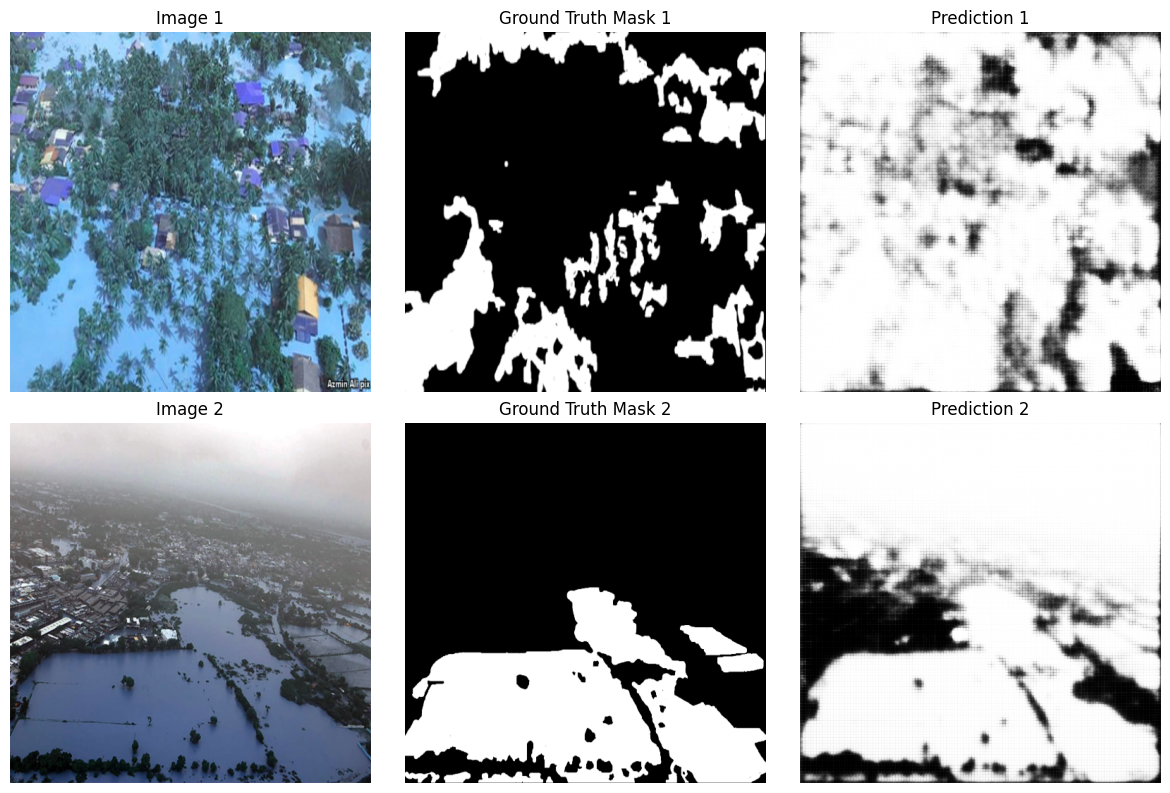

In [56]:
import matplotlib.pyplot as plt

num_imgs = len(img_test)
fig, axes = plt.subplots(num_imgs, 3, figsize=(12, 4 * num_imgs))

for i in range(num_imgs):
    axes[i, 0].imshow(img_test[i])
    axes[i, 0].set_title(f'Image {i+1}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(mask_test[i].squeeze(), cmap='gray')
    axes[i, 1].set_title(f'Ground Truth Mask {i+1}')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(pred[i].squeeze(), cmap='gray')
    axes[i, 2].set_title(f'Prediction {i+1}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

